In [67]:
import math
from abc import abstractmethod

import numpy as np
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from einops import repeat
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드
file_path = "/content/drive/MyDrive/Colab Notebooks/combined_dataset.xlsx"
df = pd.read_excel(file_path)  # read_csv -> read_excel로 변경
df

df['Hypertension'].value_counts()

# Normal을 8:2로 나눔 (훈련: 80%, 테스트: 20%)
normal_train, normal_test = train_test_split(
    df[df["Hypertension"] == "Normal"], test_size=0.2, random_state=42
)

# 나머지 클래스는 테스트 데이터에만 포함
test_data = normal_test.copy()
for category in ["Prehypertension", "Stage 1 hypertension", "Stage 2 hypertension"]:
    _, test = train_test_split(
        df[df["Hypertension"] == category], test_size=0.2, random_state=42
    )
    test_data = pd.concat([test_data, test])

# 훈련 데이터는 Normal만 포함
train_data = normal_train.copy()
train_data["Hypertension"].value_counts()
test_data["Hypertension"].value_counts()

ppg_columns = [str(i) for i in range(2091, 2101)]

# 'Hypertension'이 0 (Normal)인 데이터만 훈련 데이터로 선택
train_data = train_data[train_data["Hypertension"] == 'Normal'][ppg_columns]


# 테스트 데이터는 기존과 동일하게 유지 (Hypertension 레이블 + PPG 데이터)
test_data = test_data[["Hypertension"] + ppg_columns]

test_data['Hypertension'].value_counts()

from sklearn.preprocessing import LabelEncoder

# Label Encoding을 위한 변환기 생성
label_encoder = LabelEncoder()

# Hypertension 컬럼을 Label Encoding 적용
test_data["Hypertension_Encoded"] = label_encoder.fit_transform(test_data["Hypertension"])

# 기존 Hypertension 컬럼 제거 후 새로운 컬럼으로 대체
test_data_encoded = test_data.drop(columns=["Hypertension"]).rename(columns={"Hypertension_Encoded": "Hypertension"})
test_data_encoded['Hypertension'].value_counts()


batch_size= 32

# TensorDataset 생성
train_data_tensor = torch.tensor(train_data.values, dtype=torch.float32).unsqueeze(-1)
train_dataset = TensorDataset(train_data_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_data_tensor = torch.tensor(test_data_encoded.drop(columns=["Hypertension"]).values, dtype=torch.float32).unsqueeze(-1)

# 다시 PyTorch Tensor로 변환 및 차원 추가
test_data_tensor = torch.tensor(test_data_tensor, dtype=torch.float32).unsqueeze(-1)
test_labels_tensor = torch.tensor(test_data_encoded["Hypertension"].values, dtype=torch.float32)


<ipython-input-67-dfffdc033ab6>:123: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data_tensor = torch.tensor(test_data_tensor, dtype=torch.float32).unsqueeze(-1)


In [68]:
def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)  # Pass emb to TimestepBlock layers
            else:
                x = layer(x)  # Regular layers do not receive emb
        return x

def Normalize(in_channels):
    return nn.GroupNorm(
        num_groups=32, num_channels=in_channels, eps=1e-6, affine=True
    )


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial**2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention.
    Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(
            ch, dim=1
        )
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0, (
                f"q,k,v channels {channels} is "
                f"not divisible by num_head_channels {num_head_channels}"
            )
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = Normalize(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return self._forward(
            x,
        )

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv1d(
                self.channels, self.out_channels, 3, stride=2, padding=padding
            )#TODO:Mudar
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool1d(kernel_size=2, stride=2)#TODO: Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(
                self.channels, self.out_channels, 3, padding=padding
            )#TODO:Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class ResBlock(TimestepBlock):  # Ensure ResBlock inherits from TimestepBlock
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            Normalize(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels
                if use_scale_shift_norm
                else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            Normalize(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, kernel_size=1
            )
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        """
        Apply the ResBlock to `x` with timestep embeddings `emb`.
        """
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)

        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]

        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)

        return self.skip_connection(x) + h
class UNetModel(nn.Module):
    def __init__(
        self,
        image_size=32,
        in_channels=1,
        model_channels=32,
        out_channels=1,
        num_res_blocks=2,
        attention_resolutions=[16, 8],
        dropout=0.1,
        channel_mult=(2, 4, 8),
        num_heads=4,
        use_scale_shift_norm=False,
        resblock_updown=True,
    ):
        super().__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.use_scale_shift_norm = use_scale_shift_norm
        self.resblock_updown = resblock_updown

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv1d(in_channels, model_channels, 3, padding=1))
        ])
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, use_scale_shift_norm=use_scale_shift_norm)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch, True, out_channels=out_ch)))
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, use_scale_shift_norm=use_scale_shift_norm)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(Upsample(ch, True, out_channels=out_ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            Normalize(ch),
            nn.SiLU(),
            zero_module(nn.Conv1d(ch, out_channels, 3, padding=1)),
        )

    def forward(self, x, timesteps=None, context=None, y=None):
        assert timesteps is not None, "timesteps must be provided"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        h = x
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)

        for module in self.output_blocks:
            h_pop = hs.pop()
            if h.shape[2] != h_pop.shape[2]:
                h_pop = F.interpolate(h_pop, size=h.shape[2], mode='nearest')
            h = torch.cat([h, h_pop], dim=1)
            h = module(h, emb, context)

        return self.out(h)
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)  # Pass emb to TimestepBlock layers
            else:
                x = layer(x)  # Regular layers do not receive emb
        return x

def Normalize(in_channels):
    return nn.GroupNorm(
        num_groups=32, num_channels=in_channels, eps=1e-6, affine=True
    )


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial**2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention.
    Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(
            ch, dim=1
        )
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = th.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0, (
                f"q,k,v channels {channels} is "
                f"not divisible by num_head_channels {num_head_channels}"
            )
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = Normalize(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return self._forward(
            x,
        )

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv1d(
                self.channels, self.out_channels, 3, stride=2, padding=padding
            )#TODO:Mudar
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool1d(kernel_size=2, stride=2)#TODO: Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(
                self.channels, self.out_channels, 3, padding=padding
            )#TODO:Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class ResBlock(TimestepBlock):  # Ensure ResBlock inherits from TimestepBlock
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            Normalize(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels
                if use_scale_shift_norm
                else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            Normalize(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, kernel_size=1
            )
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        """
        Apply the ResBlock to `x` with timestep embeddings `emb`.
        """
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)

        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]

        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)

        return self.skip_connection(x) + h

from functools import partial
from inspect import isfunction

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def make_beta_schedule(
    schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3
):
    if schedule == "linear":
        betas = (
            torch.linspace(
                linear_start**0.5,
                linear_end**0.5,
                n_timestep,
                dtype=torch.float64,
            )
            ** 2
        )

    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep
            + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(
            linear_start, linear_end, n_timestep, dtype=torch.float64
        )
    elif schedule == "sqrt":
        betas = (
            torch.linspace(
                linear_start, linear_end, n_timestep, dtype=torch.float64
            )
            ** 0.5
        )
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from functools import partial

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

class DDIM(nn.Module):
    def __init__(
        self,
        unet_config,
        timesteps=1000,
        ddim_steps=50,
        beta_schedule="linear",
        clip_denoised=False,
        linear_start=1e-4,
        linear_end=2e-2,
        original_elbo_weight=0.0,
        parameterization="eps",
    ):
        super().__init__()
        assert parameterization in ["eps", "x0"], 'Only "eps" and "x0" are supported.'
        self.parameterization = parameterization
        self.model = UNetModel(**unet_config.get("params", {}))
        self.clip_denoised = clip_denoised
        self.original_elbo_weight = original_elbo_weight
        self.ddim_steps = ddim_steps
        self.register_schedule(beta_schedule, timesteps, linear_start, linear_end)

    def register_schedule(self, beta_schedule, timesteps, linear_start, linear_end):
        betas = np.linspace(linear_start, linear_end, timesteps, dtype=np.float64)
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.num_timesteps = int(timesteps)
        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer("alphas_cumprod_prev", to_torch(alphas_cumprod_prev))
        self.register_buffer("sqrt_recip_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod)))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", to_torch(np.sqrt(1.0 - alphas_cumprod)))

    def ddim_sample(self, x, t, eta=0.0):
        model_output = self.model(x, t)

        if self.parameterization == "eps":
            pred_x0 = extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x - \
                      extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape) * model_output
        else:
            pred_x0 = model_output

        if self.clip_denoised:
            pred_x0 = torch.clamp(pred_x0, -1.0, 1.0)

        sigma = eta * (1 - extract(self.alphas_cumprod, t, x.shape)).sqrt()
        noise = torch.randn_like(x)

        return pred_x0 + sigma * noise

    @torch.no_grad()
    def p_sample_loop_ddim(self, shape, eta=0.0):
        device = self.betas.device
        img = torch.randn(shape, device=device)

        for i in tqdm(reversed(range(0, self.ddim_steps)), desc="DDIM sampling"):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)
            img = self.ddim_sample(img, t, eta)

        return img

    @torch.no_grad()
    def sample(self, batch_size=16, eta=0.0):
        image_size = self.model.image_size
        channels = self.model.in_channels
        return self.p_sample_loop_ddim((batch_size, channels, image_size), eta=eta)

    def forward(self, x):
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=x.device).long()
        return self.ddim_sample(x, t)



In [69]:
EPOCHES = 5

In [70]:
import os
import torch
from torch import optim # Import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.nn.functional as F
import math

# 데이터셋 로드
batch_size = 32

# train_data_tensor는 (192, 10) 크기의 입력 데이터
train_data_tensor = torch.tensor(train_data.values, dtype=torch.float32)  # (192, 10)
train_dataset = TensorDataset(train_data_tensor)  # 레이블 없음
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_data_tensor는 (132, 10) 크기의 입력 데이터, test_labels_tensor는 (132,) 크기의 라벨
test_data_tensor = torch.tensor

# 데이터셋 로드
batch_size = 32

# train_data_tensor는 (192, 10) 크기의 입력 데이터
train_data_tensor = torch.tensor(train_data.values, dtype=torch.float32)  # (192, 10)
train_dataset = TensorDataset(train_data_tensor)  # 레이블 없음
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_data_tensor는 (132, 10) 크기의 입력 데이터, test_labels_tensor는 (132,) 크기의 라벨
test_data_tensor = torch.tensor(test_data_encoded.drop(columns=["Hypertension"]).values, dtype=torch.float32)  # (132, 10)
test_labels_tensor = torch.tensor(test_data_encoded["Hypertension"].values, dtype=torch.float32).unsqueeze(-1)  # (132, 1)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# DDIM 모델 정의 (예제)
class DDIM(nn.Module):
    def __init__(self, unet_config, timesteps=1000, ddim_steps=50, parameterization='eps'):
        super(DDIM, self).__init__()
        self.num_timesteps = timesteps
        self.ddim_steps = ddim_steps
        self.parameterization = parameterization
        self.unet = UNetModel(**unet_config["params"])  # 가정: UNet 클래스 존재

    def forward(self, x, t):
        return self.unet(x, t)


# 학습 함수
def train_ddim_model(model, train_loader, test_loader, num_epochs=20, learning_rate=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x = batch[0].to(device)  # 레이블이 없으므로 x만 가져옴
            # x = x.unsqueeze(1)  # Remove this line - it's causing the error

            # Reshape x to have the expected shape (batch_size, in_channels, image_size)
            x = x.view(x.shape[0], unet_config["params"]["in_channels"], -1)

            t = torch.randint(0, model.num_timesteps, (x.shape[0],), device=device).long()

            optimizer.zero_grad()
            loss = loss_fn(model(x, t), x)  # 모델의 출력과 입력 비교 (재구성 손실)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f}")

# 모델 초기화
device = 'cuda' if torch.cuda.is_available() else 'cpu'

unet_config = {
    "params": {
        "image_size": 10,  # feature 개수와 맞춤
        "in_channels": 10,
        "model_channels": 32,
        "out_channels": 10,  # feature 개수와 동일하게 설정
        "num_res_blocks": 2,
        "attention_resolutions": [5],
        "dropout": 0.1,
        "channel_mult": (2, 4, 8),
        "num_heads": 4,
        "use_scale_shift_norm": False,
        "resblock_updown": True,
    }
}

ddim_model = DDIM(unet_config=unet_config, timesteps=1000, ddim_steps=50, parameterization='eps').to(device)

# 학습 시작
train_ddim_model(ddim_model, train_loader, test_loader, num_epochs=EPOCHES, learning_rate=1e-4, device=device)


Epoch 1/5:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 10, 1])) that is different to the input size (torch.Size([32, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/5: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Epoch 1: Avg Train Loss = 4801429.0000


Epoch 2/5: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 2: Avg Train Loss = 4801220.3333


Epoch 3/5: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 3: Avg Train Loss = 4801009.6667


Epoch 4/5: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Epoch 4: Avg Train Loss = 4800797.5833


Epoch 5/5: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

Epoch 5: Avg Train Loss = 4800580.1667


In [71]:
test_data_tensor.shape

torch.Size([132, 10])

In [72]:
# 테스트 함수

# 테스트 함수
def test_ddim_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    loss_fn = nn.MSELoss()

    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Model"):
            x, y = batch  # x는 입력 데이터, y는 실제 라벨 (Hypertension 값)
            x, y = x.to(device), y.to(device)

            # Reshape x to have the expected shape (batch_size, in_channels, image_size)
            x = x.view(x.shape[0], unet_config["params"]["in_channels"], -1)  # Reshape to match in_channels of UNet

            t = torch.randint(0, model.num_timesteps, (x.shape[0],), device=device).long()
            pred = model(x, t)

            loss = loss_fn(pred, x)  # Calculate loss against x instead of y
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Avg Loss = {avg_loss:.4f}")

# 학습 함수

# 테스트 실행
test_ddim_model(ddim_model, test_loader, device=device)


Testing Model:  80%|████████  | 4/5 [00:00<00:00, 13.54it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 10, 1])) that is different to the input size (torch.Size([4, 10, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Testing Model: 100%|██████████| 5/5 [00:00<00:00, 15.35it/s]

Test Avg Loss = 4497591.0000


In [73]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm

def test_ddim_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    loss_fn = nn.MSELoss()

    results = []  # 결과 저장을 위한 리스트

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Model"):
            x, y = batch  # x는 입력 데이터, y는 실제 라벨 (Hypertension 값)
            x, y = x.to(device), y.to(device)

            # Reshape x to have the expected shape (batch_size, in_channels, image_size)
            x = x.view(x.shape[0], unet_config["params"]["in_channels"], -1)  # Reshape to match in_channels of UNet

            t = torch.randint(0, model.num_timesteps, (x.shape[0],), device=device).long()
            pred = model(x, t)

            loss = loss_fn(pred, x)  # Calculate loss against x instead of y

            # 결과 저장
            for i in range(x.shape[0]):
                results.append({
                    'Reconstruction_Loss': loss.item(),
                    'Label': y[i].item()
                })

    # 데이터프레임 생성
    df_results = pd.DataFrame(results)

    return df_results

# 테스트 실행
df_results = test_ddim_model(ddim_model, test_loader, device=device)

Testing Model: 100%|██████████| 5/5 [00:00<00:00, 15.60it/s]


In [74]:
# Label별 최소값과 최대값 계산
MinMax_result = df_results.groupby('Label')['Reconstruction_Loss'].agg(['min', 'max']).reset_index()
MinMax_result

,Label,min,max
0,0.0,4662753.0,4708318.0
1,1.0,4041274.5,4662753.0
2,2.0,4041274.5,4041274.5
3,3.0,4041274.5,4796478.5


In [78]:
threshold = 4662753.0

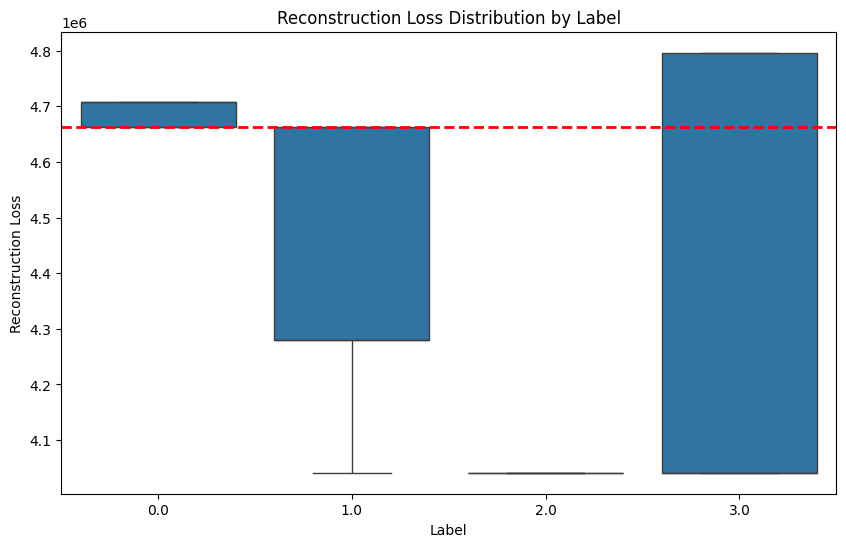

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# 박스플롯 생성
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_results["Label"], y=df_results["Reconstruction_Loss"])

plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold = {threshold}')

# 그래프 제목 및 라벨 설정
plt.title("Reconstruction Loss Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Reconstruction Loss")

# 그래프 표시
plt.show()


In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

# 이상치(Outlier) 판별 (임계값 이하인 경우 이상치로 간주)
df_results['Predicted_Outlier'] = (df_results['Reconstruction_Loss'] <= threshold).astype(int)

# 실제 이상치(1: 이상치, 0: 정상) 정의
df_results['Actual_Outlier'] = df_results['Label'].isin([1, 2, 3]).astype(int)

# 평가 지표 계산
f1 = f1_score(df_results['Actual_Outlier'], df_results['Predicted_Outlier'])
recall = recall_score(df_results['Actual_Outlier'], df_results['Predicted_Outlier'])
precision = precision_score(df_results['Actual_Outlier'], df_results['Predicted_Outlier'])
auc = roc_auc_score(df_results['Actual_Outlier'], df_results['Reconstruction_Loss'])  # AUC는 재구성 오류 값 사용

# 결과 출력
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"AUC: {auc:.4f}")



F1-score: 0.8889
Recall: 0.9524
Precision: 0.8333
AUC: 0.0794
